In [1]:
import nrrd
import napari
import os
import numpy as np
from skimage.segmentation import find_boundaries
from concurrent.futures import ThreadPoolExecutor, as_completed
import zarr
import scipy.ndimage
import blosc2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from helper import *
# from napari.utils.transforms import Affine
from magicgui import magicgui

In [2]:
#Tim skinner label testing
# current_directory = os.getcwd()
# file_name = 'data/manual_1_raw.nrrd'
# file_path = os.path.join(current_directory, file_name)
# data, _ = nrrd.read(file_path)
# label_name = 'data/manual_1_label.nrrd'
# label_path = os.path.join(current_directory, label_name)
# label, _ = nrrd.read(label_path)

In [3]:
#load zarrs
scroll_name = 's1'
s1_zarr_path = "/Volumes/16TB_RAID_0/Scroll1/Scroll1.zarr"
s1_zarr_multi_res = zarr.open(s1_zarr_path, mode='r')
s1_zarr = s1_zarr_multi_res[0]

s1_ink_zarr_path = "/Volumes/16TB_slow_RAID_0/3d_ink_zarrs/3d_predictions_scroll1.zarr"
s1_ink_zarr = zarr.open(s1_ink_zarr_path, mode='r')


print(s1_zarr.info)
print(s1_ink_zarr.info)

Name               : /0
Type               : zarr.core.Array
Data type          : uint16
Shape              : (14376, 7888, 8096)
Chunk shape        : (128, 128, 128)
Order              : C
Read-only          : True
Compressor         : None
Store type         : zarr.storage.DirectoryStore
No. bytes          : 1836138602496 (1.7T)
No. bytes stored   : 22817 (22.3K)
Storage ratio      : 80472393.5
Chunks initialized : 112/448384

Type               : zarr.core.Array
Data type          : uint8
Shape              : (7888, 8096, 14376)
Chunk shape        : (256, 256, 256)
Order              : C
Read-only          : True
Compressor         : Blosc(cname='zstd', clevel=9, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 918069301248 (855.0G)
No. bytes stored   : 281670442565 (262.3G)
Storage ratio      : 3.3
Chunks initialized : 56544/56544



In [4]:
# Zarr raw block testing

x = 3750
y = 2250
z = 0
chunk_size = 612
chunk_size_z = 612
zarr_data = s1_zarr[z:z+chunk_size_z, y:y+chunk_size, x:x+chunk_size]
data = zarr_data



label = s1_ink_zarr[ y:y+chunk_size,x:x+chunk_size, z:z+chunk_size_z ]
label = np.transpose(label, (2,0,1))

print(data.shape, label.shape)

(612, 612, 612) (612, 612, 612)


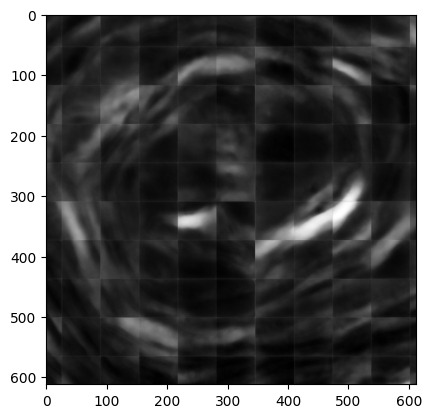

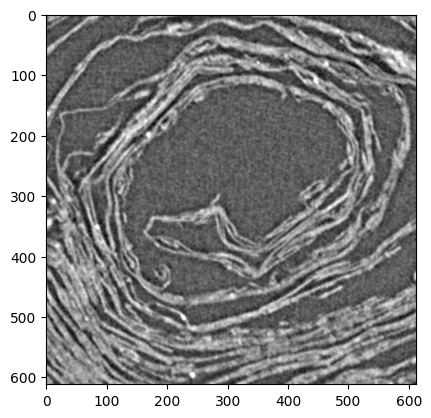

In [5]:
plt.imshow(label[0], cmap='gray')
plt.show()
plt.imshow(data[0], cmap='gray')

In [6]:
# Initialize the Napari viewer
viewer = napari.Viewer()

label_name = 'Labels'
data_name = 'Data'
border_name = 'Borders'
sheet_seperations_name = 'Sheet Seperations'
ff_name = 'flood_fill_layer'
label_3d_name = '3D Label edit layer'
border_class = 254

# Add the 3D data to the viewer
image_layer =  viewer.add_image(data, colormap='gray', name=data_name)
labels_layer = viewer.add_image(label, name=label_name)
labels_layer.blending = 'translucent'
image_layer.blending='opaque'
image_layer.depiction = 'plane'

napari.run()

In [531]:
current_directory = os.getcwd()
save_dir = current_directory+f'/data/{x}_{y}_{z}_{scroll_name}.nrrd'
print(save_dir)
# nrrd.write(save_dir, zarr_data)

/Users/jamesdarby/Documents/VesuviusScroll/GP/Vesuvius_3D_datasets/data/3500_2500_1000_s1.nrrd


In [532]:
data, _ = nrrd.read(save_dir)

In [533]:
# #Histogram of voxel values in the raw ådata
# flat_data = zarr_data.flatten()

# # Plot the histogram
# plt.figure(figsize=(10, 6))
# plt.hist(flat_data, bins=50, color='blue', edgecolor='black')
# plt.title('Histogram of Voxel Values')
# plt.xlabel('Voxel Value')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [534]:
#napari to test view the bright spots mask
# test_viewer = napari.Viewer()
# test_viewer.add_image(data, name='raw')
# test_viewer.add_labels(bright_spot_mask, name='bright spots')

# napari.run()

In [535]:
# gross volumetric labels
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'data/s1_gross_labels.b2nd')
blosc2_full_array = blosc2.open(file_path, mode='r')

label = blosc2_full_array[z:z+chunk_size, y:y+chunk_size, x:x+chunk_size]
label = label * np.logical_not(bright_spot_mask)

In [536]:
#helper functions for napari ui
from collections import deque

def limited_bfs_flood_fill(data, start_coords, max_distance):
    shape = data.shape
    filled = np.zeros(shape, dtype=bool)
    value = data[start_coords]
    
    # Directions for 6-connectivity in 3D (x, y, z)
    directions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    
    # BFS queue
    queue = deque([(start_coords, 0)])  # (coordinates, distance)
    filled[start_coords] = True

    while queue:
        (z, y, x), dist = queue.popleft()
        
        if dist < max_distance:
            for dz, dy, dx in directions:
                nz, ny, nx = z + dz, y + dy, x + dx
                
                if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                    if not filled[nz, ny, nx] and data[nz, ny, nx] == value:
                        filled[nz, ny, nx] = True
                        queue.append(((nz, ny, nx), dist + 1))

    return filled

def label_foreground_structures_napari(input_array, min_size=1000, border_class=254):
    # Find connected components in the foreground (value 2)
    foreground = input_array > 0
    foreground[foreground == border_class] = 0

    # Label connected components
    labeled_array, num_features = scipy.ndimage.label(foreground)
    
    # Measure the size of each connected component
    structure_sizes = np.array(scipy.ndimage.sum(foreground, labeled_array, range(num_features + 1)))
    
    # Create a mask to remove small structures
    remove_mask = structure_sizes < min_size
    remove_mask[0] = 0  # Ensure the background is not removed

    # Remove small structures
    labeled_array[remove_mask[labeled_array]] = 0

    # Relabel the structures after removal
    labeled_array, num_features = scipy.ndimage.label(labeled_array > 0)

    print(f"Number of connected foreground structures before filtering: {num_features}")
    print(f"Number of connected foreground structures after filtering: {np.max(labeled_array)}")
    
    labeled_array[input_array == border_class] = border_class # Add the border class back in

    return labeled_array


### Additional custom keybinds:<br>
q to decrease brush size<br>
e to increase brush size<br>
w to select label layer that was last clicked in move mode, alternatively use color picker (4)<br>
s to toggle show selected label<br>
a to decrease selected label value<br>
d to increase selected label value<br>
arrow keys scrub through layers<br>
r or / to toggle label visibility<br>
t to toggle borders visibility<br>
f or down arrow for 20 iter flood fill<br>
g or up arrow for 100 iter flood fill<br>

In [537]:
#stable napari extensions

# Initialize the Napari viewer
viewer = napari.Viewer()

label_name = 'Labels'
data_name = 'Data'
border_name = 'Borders'
sheet_seperations_name = 'Sheet Seperations'
ff_name = 'flood_fill_layer'
label_3d_name = '3D Label edit layer'
border_class = 254

# Add the 3D data to the viewer
image_layer =  viewer.add_image(data, colormap='gray', name=data_name)
labels_layer = viewer.add_labels(label, name=label_name)

@viewer.bind_key('h')
def save_labels(viewer):
    msg = 'save labels'
    viewer.status = msg
    print(msg)
    current_directory = os.getcwd()
    file_path = f'output/volumetric_labels/'
    output_path = os.path.join(current_directory, file_path)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    print(labels_layer.data.shape, labels_layer.data.dtype)
    nrrd.write(os.path.join(output_path,f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_label.nrrd"), labels_layer.data)

    if sheet_seperations_name in viewer.layers:
        nrrd.write(os.path.join(output_path,f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_sheet_seperations.nrrd"), viewer.layers[sheet_seperations_name].data)

@viewer.bind_key('v')
def draw_border_class(viewer):
    msg = 'draw border class'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = border_class
    labels_layer.brush_size = 2
    labels_layer.mode = 'paint'

@viewer.bind_key('c')
def connected_components(viewer):
    msg = 'connected components'
    viewer.status = msg
    print(msg)

    #mask for the border class from the labels layer
    mask = (labels_layer.data == border_class)
    old_borders = np.zeros_like(labels_layer.data)
    old_borders[labels_layer.data == border_class] = border_class

    #new borders from the sheet seperations layer and labels layer
    new_borders = viewer.layers[sheet_seperations_name].data | old_borders
    new_borders[new_borders > 0] = border_class

    if sheet_seperations_name in viewer.layers:
        mask_2 = (viewer.layers[sheet_seperations_name].data == border_class)
        mask = mask | mask_2
        viewer.layers[sheet_seperations_name].data = new_borders
    else:
        viewer.add_labels(new_borders, name=sheet_seperations_name)

    #connected components data with both layer's borders removed
    cc_data = labels_layer.data.copy()
    cc_data[mask] = 0

    labels_layer.data = label_foreground_structures_napari(cc_data, border_class= border_class, min_size=1000)
    msg = 'connected components finished'
    viewer.status = msg
    print(msg)


@viewer.bind_key('r')
def toggle_labels_visibility(viewer):
    msg = 'toggle labels visibility'
    viewer.status = msg
    print(msg)
    if viewer.dims.ndisplay == 3 and label_3d_name in viewer.layers:
        viewer.layers[label_3d_name].visible = not viewer.layers[label_3d_name].visible
    else:
        labels_layer.visible = not labels_layer.visible

viewer.bind_key('/', toggle_labels_visibility)

@viewer.bind_key('t')
def toggle_borders_visibility(viewer):
    msg = 'toggle borders visibility'
    viewer.status = msg
    print(msg)
    if border_name in viewer.layers:
        viewer.layers[border_name].visible = not viewer.layers[border_name].visible

@viewer.bind_key('q')
def decrease_brush_size(viewer):
    msg = 'decrease brush size'
    viewer.status = msg
    print(msg)
    labels_layer.brush_size = labels_layer.brush_size - 1

@viewer.bind_key('e')
def increase_brush_size(viewer):
    msg = 'increase brush size'
    viewer.status = msg
    print(msg)
    labels_layer.brush_size = labels_layer.brush_size + 1

@viewer.bind_key('s')
def toggle_show_selected_label(viewer):
    msg = 'toggle show selected label'
    viewer.status = msg
    print(msg)
    labels_layer.show_selected_label = not labels_layer.show_selected_label

@viewer.bind_key('a')
def decrease_selected_label(viewer):
    msg = 'decrease selected label'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = labels_layer.selected_label - 1

@viewer.bind_key('d')
def increase_selected_label(viewer):
    msg = 'increase selected label'
    viewer.status = msg
    print(msg)
    labels_layer.selected_label = labels_layer.selected_label + 1

# Function to capture cursor information when 'w' is pressed
def capture_cursor_info(event):
    # Get cursor position in world coordinates
    position = viewer.cursor.position

    # Convert world coordinates to data indices
    indices = tuple(int(np.round(coord)) for coord in position)

    # Get the value of the label under the cursor
    label_value = labels_layer.data[indices]

    # Print the cursor position and label value
    print(f"Cursor Position: {indices}, Label Value: {label_value}")
    labels_layer.selected_label = label_value

# Bind the function to the 'w' key press event
@viewer.bind_key('w')
def on_w_key(event):
    capture_cursor_info(event)

@viewer.bind_key('x')
def interpolate_borders(viewer):
    msg = 'interpolating borders'
    viewer.status = msg
    print(msg)
    interpolated_borders = interpolate_slices(labels_layer.data, border_class)
    if sheet_seperations_name in viewer.layers:
        viewer.layers[sheet_seperations_name].data = interpolated_borders
    else:
        viewer.add_labels(interpolated_borders, name=sheet_seperations_name)

# Add an empty labels layer for the flood fill result
flood_fill_layer = viewer.add_labels(np.zeros_like(data), name=ff_name)

# Global variable to hold the current flood fill distance
current_distance = 20

@viewer.bind_key('f')
def flood_fill(viewer, distance=20):
    msg = 'flood fill'
    viewer.status = msg
    print(msg)
    # Get the cursor position in data coordinates
    cursor_position = viewer.cursor.position
    cursor_position = tuple(int(np.round(coord)) for coord in cursor_position)

    # Get the current labels layer
    labels_layer = viewer.layers[label_name]

    # Get the current labels
    labels = labels_layer.data

    # Perform the flood fill operation
    flood_fill_result = limited_bfs_flood_fill(labels, cursor_position, distance)

    # Update the flood fill layer with the result
    flood_fill_layer.data = flood_fill_result

@viewer.bind_key('g')
def on_g_event(viewer):
    flood_fill(viewer, 100)

@viewer.bind_key('Up')
def on_up_arrow_event(viewer):
    flood_fill(viewer, 100)

@viewer.bind_key('Down')
def on_down_arrow_event(viewer):
    flood_fill(viewer, 20)

Context leak detected, msgtracer returned -1


In [538]:
#dev napari extensions
# Function to shift the plane along its normal vector
def shift_plane(layer, direction):
    if viewer.dims.ndisplay == 3 and layer.depiction == 'plane':
        # Get the current position and normal of the plane
        current_position = np.array(layer.plane.position)
        normal_vector = np.array(layer.plane.normal)

        # Calculate the new position
        new_position = current_position + direction * normal_vector

        # Update the plane position
        layer.plane.position = tuple(new_position)
        print(f"Shifted plane to {direction} along the normal: new position = {new_position}")
    else:
        # If in 2D mode, shift the slice by 1
        current_step = viewer.dims.current_step[0]
        new_step = current_step + (-direction)
        viewer.dims.set_current_step(0, new_step)
        print(f"Shifted 2D slice to: {new_step}")


@viewer.bind_key('Left')
def on_left_arrow_event(viewer):
    shift_plane(viewer.layers[data_name], 1)
    if viewer.dims.ndisplay == 3 and viewer.layers[label_3d_name].visible:
        cut_label_at_plane(viewer)

@viewer.bind_key('Right')
def on_right_arrow_event(viewer):
    shift_plane(viewer.layers[data_name], -1)
    if viewer.dims.ndisplay == 3 and viewer.layers[label_3d_name].visible:
        cut_label_at_plane(viewer)



@viewer.bind_key('\\')
def switch_to_plane(viewer):
   # Switch to 3D mode
    if viewer.dims.ndisplay == 3:
        viewer.dims.ndisplay = 2
        for layer in viewer.layers:
            if layer.name != label_3d_name:
                viewer.layers[layer.name].visible = True
            else:
                viewer.layers[layer.name].visible = False
        viewer.layers.selection.active = viewer.layers[label_name]
        viewer.layers[label_name].contour = 1

    else:
        step_val = viewer.dims.current_step
        print(f"Current step: {step_val}")
        viewer.dims.ndisplay = 3
    
        # Hide all layers except the one named `data_name`
        for layer in viewer.layers:
            if layer.name != data_name and layer.name != ff_name:
                viewer.layers[layer.name].visible = False
            
            elif layer.name == data_name:
                # Change the depiction of `data_name` layer from volume to plane
                viewer.layers[layer.name].visible = True
                viewer.layers[layer.name].depiction = 'plane'
                viewer.layers[layer.name].plane.position = (step_val[0], 0, 0)
                viewer.layers[layer.name].affine = np.eye(3)  # Ensure the affine transform is identity for proper rendering
                viewer.layers[layer.name].blending = 'opaque'
                viewer.layers.selection.active = viewer.layers[layer.name]

# Variable to store the oblique plane information
oblique_plane_info = {
    'position': (32, 32, 32),
    'normal': (1, 0, 0)
}

# Persistent variables to store the previous state and mask
previous_label_3d_data = None
manual_changes_mask = None

def cut_label_at_plane(viewer):
    global previous_label_3d_data, manual_changes_mask

    data_plane = viewer.layers[data_name]
    if data_plane.depiction != 'plane':
        print("Please switch to plane mode by pressing '\\' key.")
        return
    
    position = data_plane.plane.position
    normal = data_plane.plane.normal
    viewer.layers[data_name].blending = 'opaque'

    # Create a meshgrid for the label data coordinates
    z, y, x = np.meshgrid(np.arange(label_data.shape[0]),
                          np.arange(label_data.shape[1]),
                          np.arange(label_data.shape[2]),
                          indexing='ij')

    # Calculate the distance of each voxel from the plane
    distances = (x - position[2]) * normal[2] + (y - position[1]) * normal[1] + (z - position[0]) * normal[0]

    # Create a copy of the label data and set all voxels between the viewer and the plane to 0
    new_label_data = labels_layer.data.copy()
    new_label_data[distances > 1] = 0

    # Check if the label_3d_name layer already exists
    if label_3d_name in viewer.layers:
        existing_layer = viewer.layers[label_3d_name]
        if isinstance(existing_layer, napari.layers.Labels):
            # Calculate the manual changes mask
            if previous_label_3d_data is not None:
                manual_changes_mask = existing_layer.data != previous_label_3d_data
            
            # Apply the manual changes to the label_name layer
            label_name_layer = viewer.layers[label_name]
            label_name_layer.data[manual_changes_mask] = existing_layer.data[manual_changes_mask]

    # Remove the old label_3d_name layer if it exists
    visible_state = True
    if label_3d_name in viewer.layers:
        visible_state = viewer.layers[label_3d_name].visible
        viewer.layers.remove(viewer.layers[label_3d_name])
    
    # Add a new label layer with the updated data
    viewer.add_labels(new_label_data, name=label_3d_name)
    viewer.layers[label_3d_name].visible = visible_state

    # Store the current state of the label_3d_name layer for future comparison
    previous_label_3d_data = new_label_data.copy()

# Function to cut the label layer at the oblique plane
@viewer.bind_key(']')
def cut_label_at_oblique_plane(viewer):
    if viewer.dims.ndisplay == 3:
        cut_label_at_plane(viewer)
        viewer.layers[label_3d_name].visible = True

# Make axes visible by default
viewer.axes.visible = True
labels_layer.n_edit_dimensions = 3
labels_layer.brush_size = 5
labels_layer.opacity = 0.5
labels_layer.contour = 1

file_path = 'output/volumetric_labels/'
label_path = os.path.join(current_directory, file_path, f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_label.nrrd")
if os.path.exists(label_path):
    label_data, _ = nrrd.read(label_path)
    label_data = label_data * np.logical_not(bright_spot_mask(data))
    labels_layer.data = label_data


sheet_seperations_path = os.path.join(current_directory, file_path, f"{x}_{y}_{z}_xyz_{chunk_size}_chunk_{scroll_name}_vol_sheet_seperations.nrrd")
if os.path.exists(sheet_seperations_path):
    data, _ = nrrd.read(sheet_seperations_path)
    viewer.add_labels(data, name=sheet_seperations_name)

viewer.layers.selection.active = viewer.layers[label_name]

# Start the Napari event loop
napari.run()

Current step: (127, 127, 127)


/Users/jamesdarby/anaconda3/envs/ML_Normals/lib/python3.12/site-packages/napari/layers/labels/labels.py:945: UserWarning: Contours are not displayed during 3D rendering
  warnings.warn(


toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
toggle labels visibility
Shifted plane to -1 along the normal: new position = [135.14668454 172.05967581  58.55869592]
Shifted plane to -1 along the normal: new position = [134.30880704 171.98534863  59.09947015]
Shifted plane to 1 along the normal: new position = [135.14668454 172.05967581  58.55869592]
Shifted plane to 1 along the normal: new position = [135.98456204 172.134003    58.0179217 ]
Shifted plane to 1 along the normal: new position = [136.82243954 172.20833019  57.47714747]
Shifted plane to 1 along the normal: new position = [137.66031704 172.28265737  56.93637325]
Shifted plane to 1 along the normal: new position = [138.49819454 172.35698456  56.39559902]
Shifted plane to 1 along the normal: new position = [139.33607205 172.43131175  55.8548248 ]
Shifted plane to 1 along the 